In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from statistical_clear_sky.utilities.data_conversion import make_time_series
from statistical_clear_sky.utilities.filters import lowpass_2d
from statistical_clear_sky.algorithm.utilities.time_shifts import fix_time_shifts
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [3]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [3]:
df = load_sys(47, local=False)

47 6066


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2012-02-15 2017-07-30


In [5]:
end - start

Timedelta('1992 days 00:00:00')

Text(0,0.5,'kW')

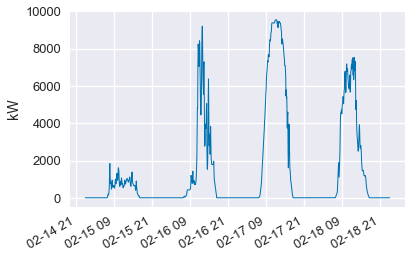

In [6]:
pa = PLOT_ARGS
pa['figsize'] = (6,4)
df.loc[start.strftime('%m/%d/%y'):(start + 3).strftime('%m/%d/%y')].plot(legend=False, **pa)
plt.ylabel('kW')

In [7]:
power_signals_d = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
p = df.loc[start:end]

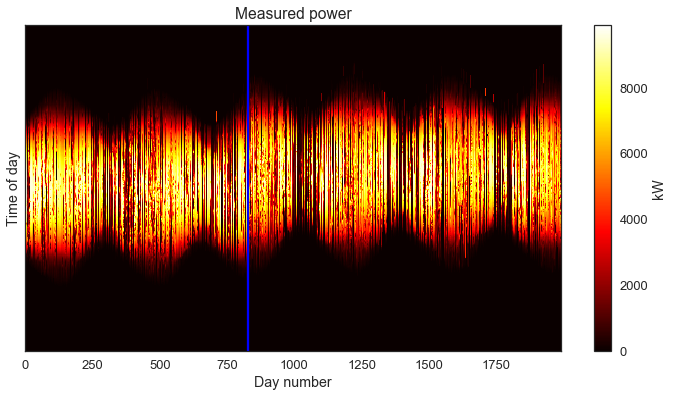

In [8]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(D[:, :], cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    ax.axvline(812+15, color='blue')

/Users/bennetmeyers/.virtualenvs/clearsky/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


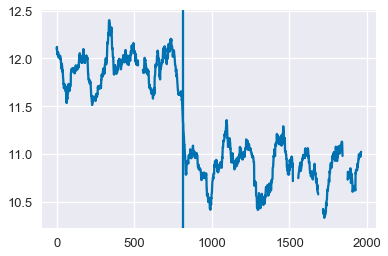

In [9]:
w = 30
sc = 20
s1 = np.convolve(np.divide(np.dot(np.linspace(0, 24, power_signals_d.shape[0]), power_signals_d), np.sum(power_signals_d, axis=0)), np.ones(w), mode='valid') / w
plt.plot(range(len(s1)), s1)
plt.axvline(812)

In [10]:
from from statistical_clear_sky.utilities.filters import edge_find_1d

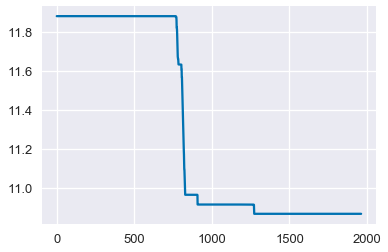

0.06745372774019565


[812]

In [11]:
edge_find_1d(s1, debug=True, tol=5e-2)

../clearsky/utilities.py:207: RuntimeWarning: invalid value encountered in true_divide
  s1 = np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0))


2 segments found
index locations:  [827]


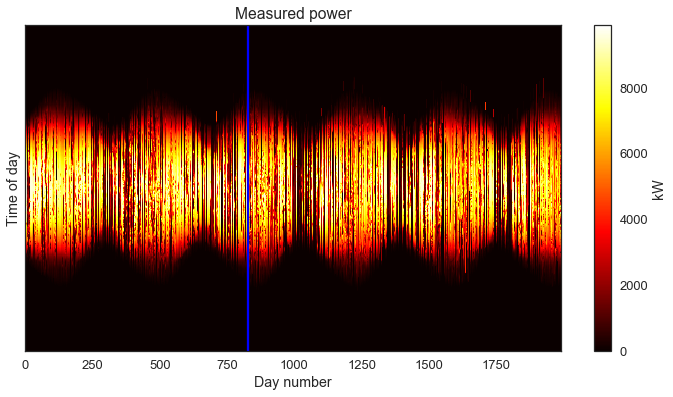

In [12]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(fix_time_shifts(power_signals_d, verbose=True), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    ax.axvline(812+15, color='blue')

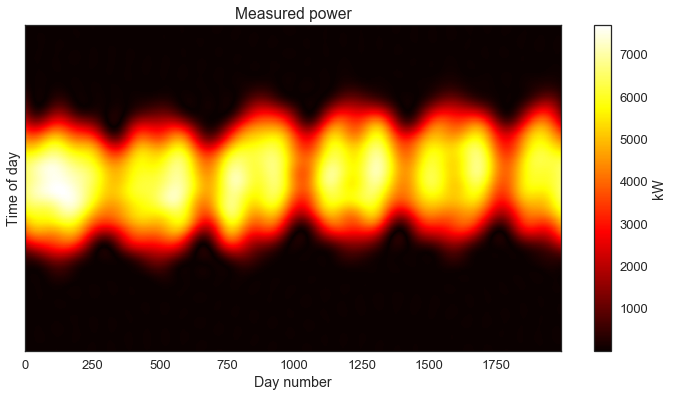

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(lowpass_2d(power_signals_d, r=15), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

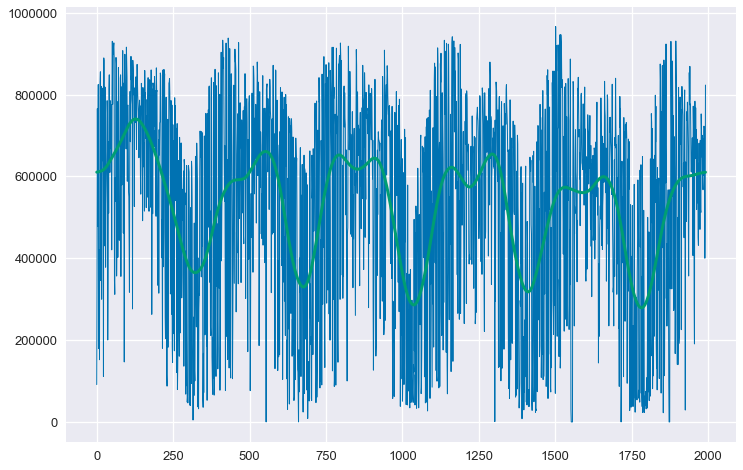

In [14]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(power_signals_d, axis=0), linewidth=1)
plt.plot(np.sum(lowpass_2d(power_signals_d, r=15), axis=0), linewidth=3)

In [15]:
u, sig, vt = np.linalg.svd(D, full_matrices=False)
u[:, 0] *= -1
vt[0] *= -1

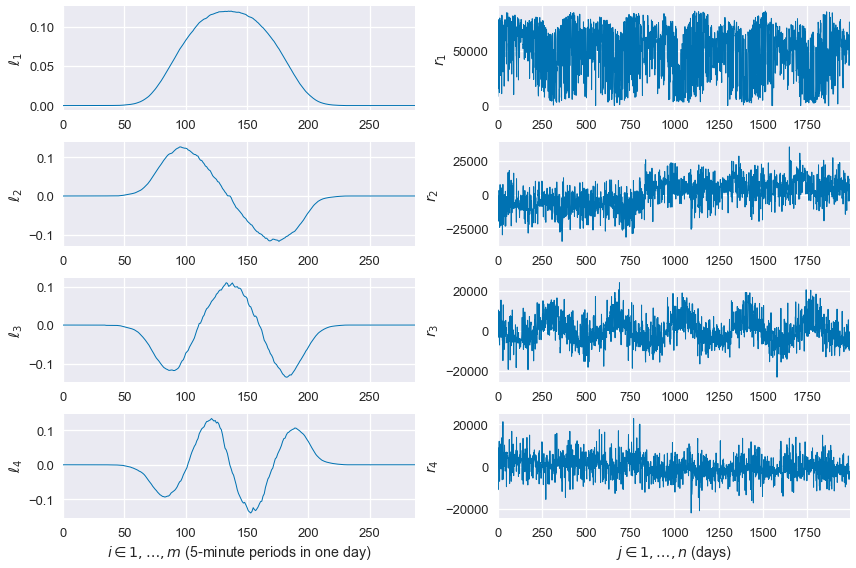

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(u.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(sig).dot(vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, power_signals_d.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [17]:
iterative_fitting = IterativeFitting(power_signals_d, rank_k=4, solver_type=SolverType.mosek)

In [18]:
import cvxpy as cvx
try:
    iterative_fitting.execute(mu_l=1e5, mu_r=1e3, tau=0.9, max_iteration=10, exit_criterion_epsilon=5e-3, 
                              max_degradation=None, min_degradation=None)
except cvx.SolverError:
    print('solver failed!')

starting at 2876326870.771 [13197103.082715912, 7012.234342078048, 2229414525.809128, 633708229.6449116]
iteration 1: 12814435.114 [1.23678236e+07 2.46048800e+03 4.44110549e+05 4.04730000e+01]
iteration 2: 11067681.985 [1.06502420e+07 3.84870400e+03 4.13508432e+05 8.28600000e+01]
iteration 3: 10880654.422 [1.04659994e+07 4.15307800e+03 4.10500269e+05 1.71600000e+00]
iteration 4: 10836371.946 [1.04231243e+07 4.40631200e+03 4.08839598e+05 1.75400000e+00]
Minimization complete in 5.58 minutes


In [19]:
clearsky = iterative_fitting.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - iterative_fitting.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

102973.69692348625


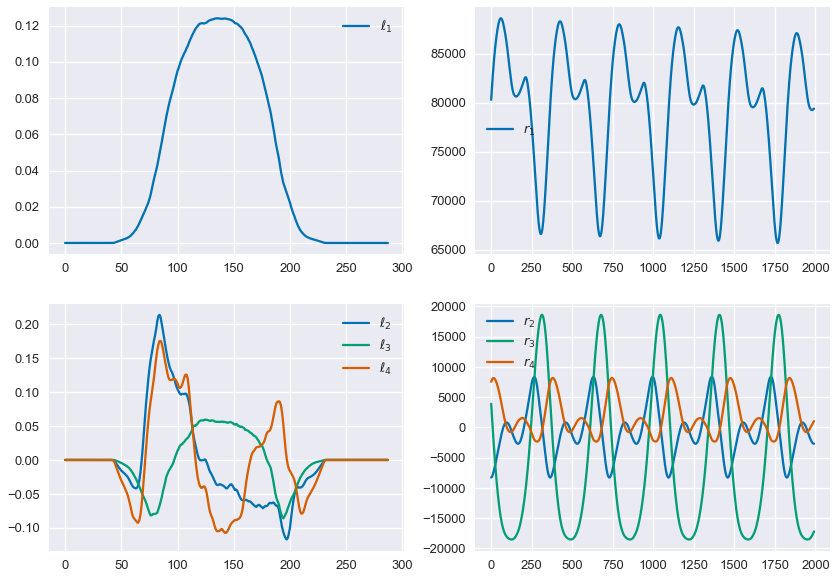

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0])
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [21]:
iterative_fitting.beta_value

array(-0.00343547)

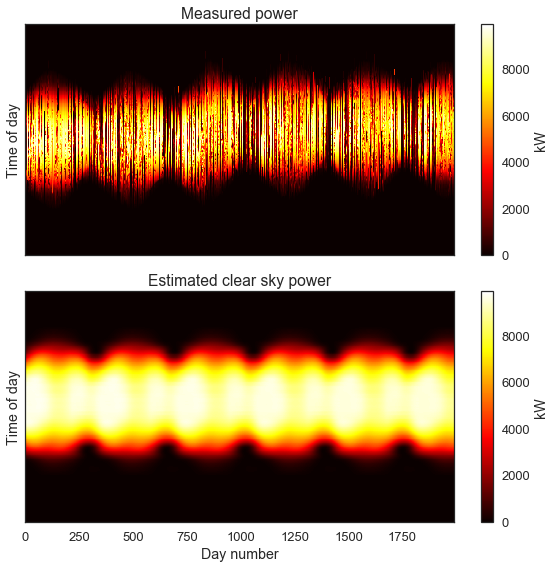

In [22]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(iterative_fitting.power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot',
                       vmin=0, vmax=np.max(iterative_fitting.power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

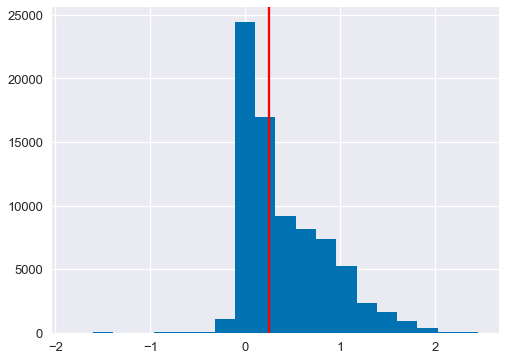

0.25576448709141264 0.44730187876747


In [23]:
# scale residuals by daily weight, which sets many days to zero. 
w1 = np.diag(iterative_fitting.weights)
wres = np.dot(iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d, w1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(iterative_fitting.power_signals_d[:, use_days])
final_metric = scaled_wres[iterative_fitting.power_signals_d[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

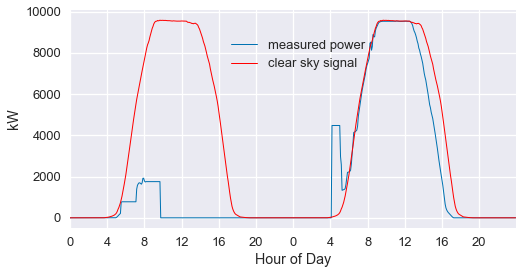

In [24]:
d1 = 1500
d2 = d1 + 2
actual = p[d1*288:d2*288].values
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [25]:
iterative_fitting = IterativeFitting(fix_time_shifts(power_signals_d, verbose=True), rank_k=4, solver_type=SolverType.mosek)

../clearsky/utilities.py:207: RuntimeWarning: invalid value encountered in true_divide
  s1 = np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0))


2 segments found
index locations:  [827]


In [26]:
import cvxpy as cvx
try:
    iterative_fitting.execute(mu_l=1e5, mu_r=1e3, tau=0.9, max_iteration=10, exit_criterion_epsilon=5e-3, 
                              max_degradation=None, min_degradation=None)
except cvx.SolverError:
    print('solver failed!')

starting at 2815646025.133 [11732276.925881816, 8136.349383789787, 2237239162.909258, 566666448.9489329]
iteration 1: 7978005.329 [7.48478114e+06 2.71863600e+03 4.90505329e+05 2.24000000e-01]
iteration 2: 7019178.159 [6.55984962e+06 4.92500900e+03 4.54375719e+05 2.78090000e+01]
iteration 3: 6896672.121 [6.45726718e+06 6.18092200e+03 4.33212762e+05 1.12590000e+01]
iteration 4: 6651447.874 [6.23399046e+06 7.19143500e+03 4.10265682e+05 2.92000000e-01]
iteration 5: 6583606.797 [6.17366252e+06 8.29996500e+03 4.01642758e+05 1.55600000e+00]
iteration 6: 6567799.813 [6.16056828e+06 9.06598000e+03 3.98164583e+05 9.69000000e-01]
Minimization complete in 8.11 minutes


In [27]:
clearsky = iterative_fitting.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - iterative_fitting.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

86129.11243818312


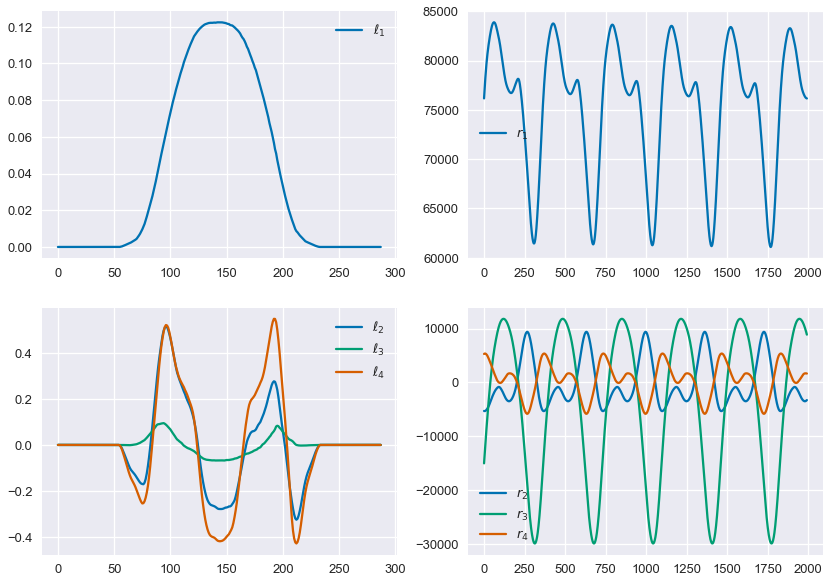

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0])
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [29]:
iterative_fitting.beta_value

array(-0.00143653)

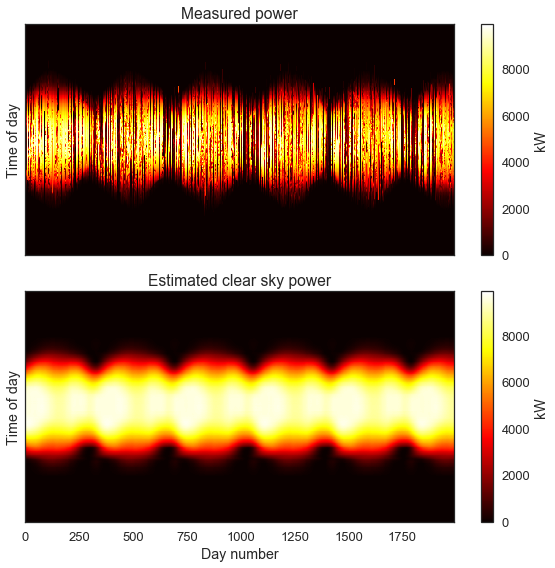

In [30]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(iterative_fitting.power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot',
                       vmin=0, vmax=np.max(iterative_fitting.power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

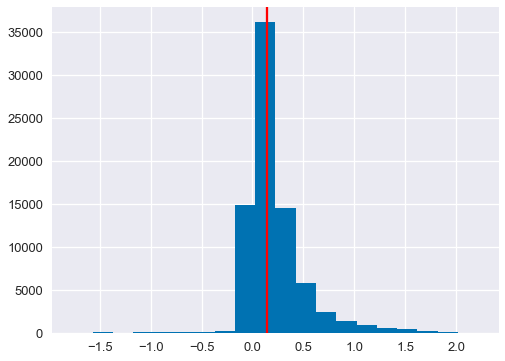

0.13863929567087616 0.29008277388058773


In [31]:
# scale residuals by daily weight, which sets many days to zero. 
w1 = np.diag(iterative_fitting.weights)
wres = np.dot(iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d, w1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(iterative_fitting.power_signals_d[:, use_days])
final_metric = scaled_wres[iterative_fitting.power_signals_d[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

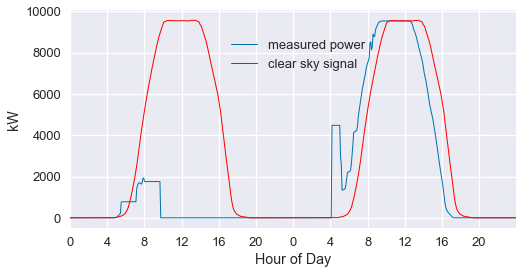

In [32]:
d1 = 1500
d2 = d1 + 2
actual = p[d1*288:d2*288].values
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [33]:
print(sum(iterative_fitting.l_cs_value.shape) + sum(iterative_fitting.r_cs_value.shape))

2288


(0, 1440)

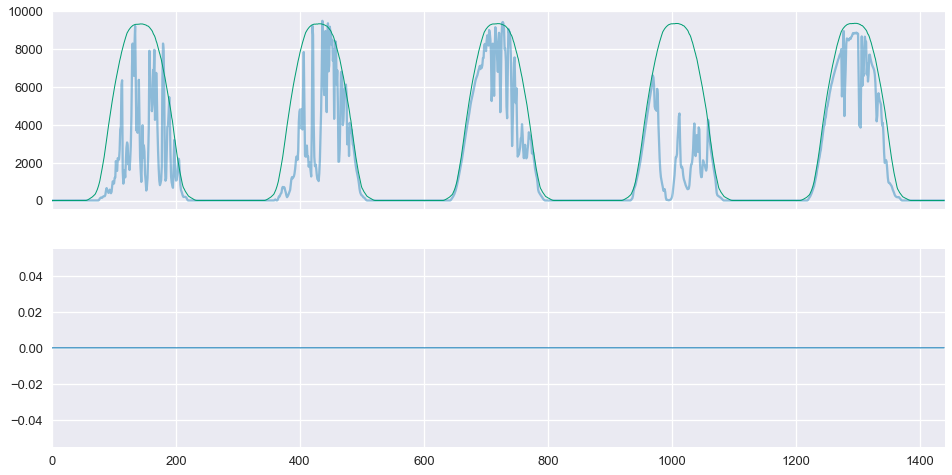

In [34]:
d1 = 200
d2 = d1+5
actual = p[d1*288:d2*288].values
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(d2-d1))

In [35]:
iterative_fitting.beta_value

array(-0.00143653)

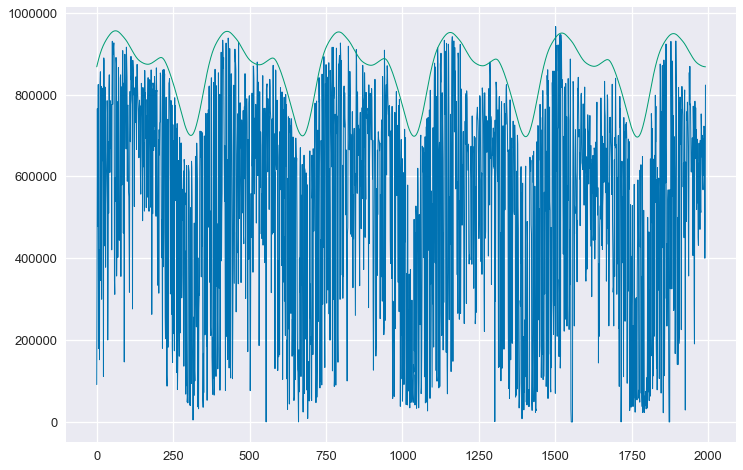

In [36]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(power_signals_d, axis=0), linewidth=1)
plt.plot(iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]), linewidth=1)

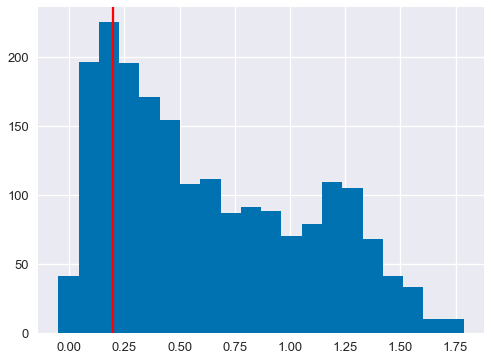

0.1962495969311336


In [37]:
residuals1 = (iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]) - np.sum(power_signals_d, axis=0)) / np.average(np.sum(power_signals_d, axis=0))
plt.figure(figsize=(8,6))
plt.hist(residuals1, bins=20)
plt.axvline(np.percentile(residuals1, 20), color='r')
plt.show()
print(np.percentile(residuals1, 20))

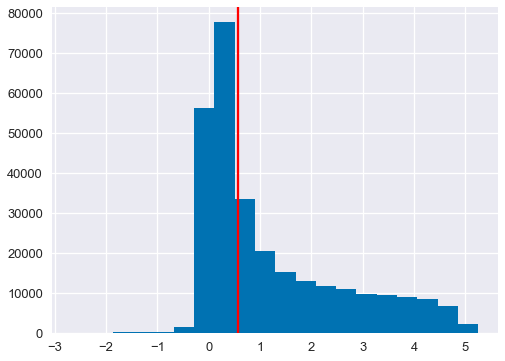

0.5715073097780807


In [38]:
residuals2 = ((power_signals_d - iterative_fitting.power_signals_d) / np.average(iterative_fitting.power_signals_d))[iterative_fitting.power_signals_d > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(residuals2, bins=20)
plt.axvline(np.percentile(residuals2, 50), color='r')
plt.show()
print(np.percentile(residuals2, 50))

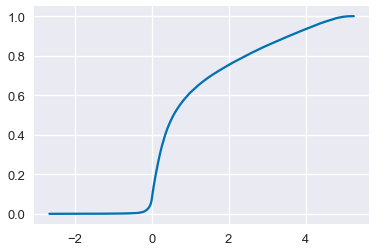

In [39]:
plt.plot(np.sort(residuals2), np.linspace(0, 1, len(residuals2), endpoint=False))

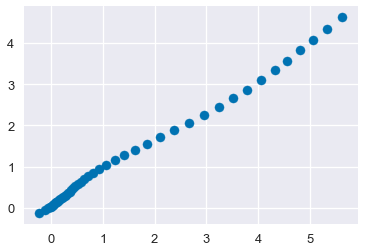

In [40]:
gq = np.load('good_quantiles.npy')
testq = np.percentile(residuals2, np.arange(2, 99, 2))
plt.scatter(gq, testq)

In [41]:
np.std(residuals2)

1.3808429008994787

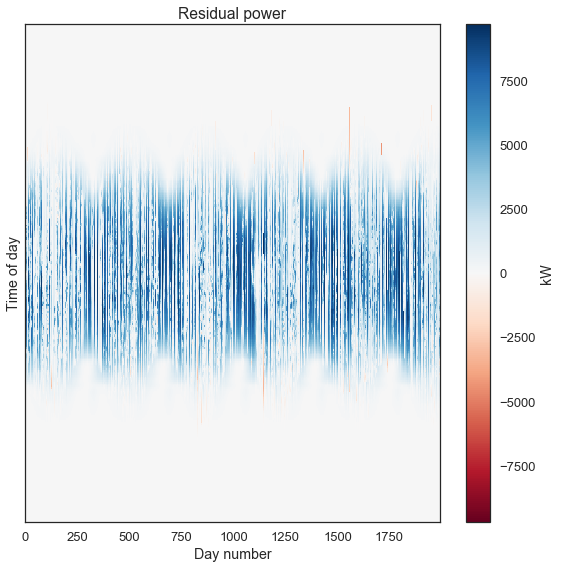

In [42]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

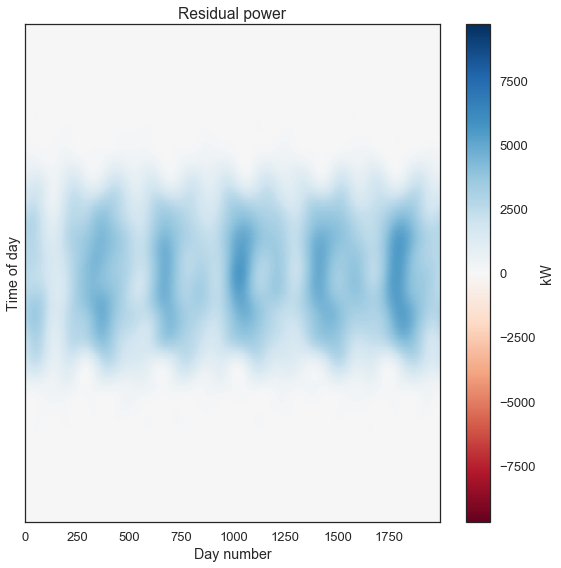

In [43]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

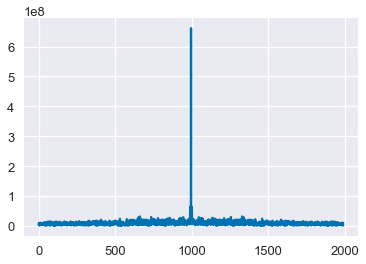

In [44]:
a = np.fft.fft2(r)[0]
plt.plot(np.abs(np.fft.fftshift(a)))